![logo](./figures/LogoLine_horizon_C3S.png)

# Climate Stripes
This Jupyter Notebook reproduces the climate stripes product from the C3S Atlas.

The climate stripes project is inspired by the “warming stripes” graphics (introduced by Ed Hawkins, https://www.ShowYourStripes.info), which are simple and compelling visual representations of the change in temperature using a series of coloured stripes chronologically ordered; stripes reflect a minimalist style, conceived to use colour alone to avoid technical distractions when conveying information to non-scientists. Climate stripes are implemented in the C3S Atlas using chronologically ordered vertical bars along the period (spanning historical and projected simulations) to represent annual/seasonal raw values or changes (anomalies relative to the selected baseline in this case) of the selected variable and scenario. The stripes are divided vertically to represent each of the simulations/models forming the ensemble (with the ensemble median at the top). Colors blue/brown to red/green indicate negative to positive changes (or minimum to maximum values).

Note that climate stripes can be used for variables other than temperature to detect climate signals in the ensemble over time. In the case of the current notebook, precipitation is used

The figure below represents the climate stripe of precipitation for CMIP6 projections. It can be visualized in the C3S Atlas using the following [Permalink](https://atlas.climate.copernicus.eu/atlas/KlG1w3e0)

![stripe](./figures/pr-CMIP6_stripes.png)

### Load Python packages and clone and install the c3s-atlas GitHub repository from the ecmwf-projects

Clone (`git clone`) the [c3s-atlas](https://github.com/ecmwf-projects/c3s-atlas) repository and install them (`pip install -e .`).

Further details on how to clone and install the repository are available in the [requirements section](https://github.com/ecmwf-projects/c3s-atlas?tab=readme-ov-file#requirements)

In [6]:
import xarray as xr
import glob
import os
from datetime import date
import numpy as np
from pathlib import Path
import cdsapi
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from c3s_atlas.utils import (
    season_get_name,
    extract_zip_and_delete,
)
from c3s_atlas.customized_regions import (
    Mask
)
from c3s_atlas.analysis import (
    annual_weighted_average, 
)
from c3s_atlas.products import (
    climate_stripe_plot,
)
from c3s_atlas.GWLs import (
    load_GWLs,
    select_member_GWLs,
    get_selected_data
)

### Download climate data with the CDS API
To reduce data size and download time, a geographical subset focusing on a specific area within the European region (Spain) is selected.

- Catalogue: [Gridded dataset underpinning the Copernicus Interactive Climate Atlas](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview)

In [18]:
cdsapi_url= "https://cds.climate.copernicus.eu/api"
cdsapi_key= ""

In [ ]:
c = cdsapi.Client(url=cdsapi_url, key=cdsapi_key)

> ⚠️ **Warning: Exposed API Credentials**
>
> For security reasons, it is not recommended to hardcode your Copernicus Climate Data Store (CDS) API credentials — such as `cdsapi_url` and `cdsapi_key` — directly in notebooks.
>
> Instead, it is best to store them securely in a `.cdsapirc` file located in your home directory.
>
> 📄 More info: [CDS API - How to use the API](https://cds.climate.copernicus.eu/how-to-api)

In [20]:
project = "CMIP6"
scenario = "ssp370"
var = 'r'
# directory to download the files
dest = Path('./data/CMIP6')
os.makedirs(dest, exist_ok=True)

##### Download historical data

In [ ]:
filename = 'r_CMIP6_historical_mon_185001-201412.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    "origin": "cmip6",
    "experiment": "historical",
    "period": "1850-2014",
    "variable": "monthly_precipitation",
    "bias_adjustment": "no_bias_adjustment",
    'area': [44.5, -9.5, 35.5, 3.5]
}

c.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

##### Download SSP scenario

In [ ]:
filename = 'r_CMIP6_ssp370_mon_201501-210012.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    "origin": "cmip6",
    "experiment": "ssp3_7_0",
    "period": "2015-2100",
    "variable": "monthly_precipitation",
    "bias_adjustment": "no_bias_adjustment",
    'area': [44.5, -9.5, 35.5, 3.5]
}

c.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

#### Concatenate historical and SSP scenarios
Note that the historical and SSP scenarios may have a different number of members. Here, common members from the historical and SSP scenarios are concatenated into a single [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) to facilitate their use going forward.

In [23]:
ds_hist = xr.open_dataset(dest / "r_CMIP6_historical_mon_185001-201412.nc")
ds_sce = xr.open_dataset(dest / "r_CMIP6_ssp370_mon_201501-210012.nc")
mem_inters = np.intersect1d(ds_hist.member_id.values, ds_sce.member_id.values)
ds_hist = ds_hist.isel(member = np.isin(ds_hist.member_id.values, mem_inters))
ds_sce = ds_sce.isel(member = np.isin(ds_sce.member_id.values, mem_inters))
ds = xr.concat([ds_hist, ds_sce], dim = 'time')

##### Define season

In [24]:
season = [3, 4, 5] # Months

In [25]:
attrs = {
    "project" : project,
    "scenario": scenario,
    "variable": var,
    "season": season,
    "season_name" : season_get_name(season),
    "actual_year": date.today().year,
    "unit" : ds[var].units    
}

#### Select region
The Spanish region is used as an example from the predefined European countries regions to visualize the products. See [customized_regions.ipynb](https://github.com/ecmwf-projects/c3s-atlas/blob/main/book/notebooks/customized_regions.ipynb) notebook for more options and information.

In [26]:
mask = Mask(ds).European_contries(['ESP'])
filtered_ds=ds.where(mask)

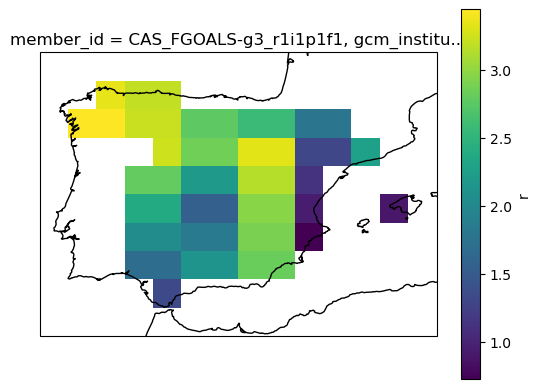

In [27]:
# mean spatial map for one member
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for lat/lon projections
filtered_ds[var].isel(member=0).mean(dim='time').plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

### Analysis for the product
The **annual_weighted_average** function calculates the yearly spatial mean of a dataset, weighted by the cosine of the latitude. This is a common approach to account for the varying size of grid cells at different latitudes, as areas near the poles have smaller grid cells than those near the equator. By applying this weighting, the function ensures that each grid cell contributes appropriately to the overall average, regardless of its geographical location.

In [28]:
climate_stripe_ds = annual_weighted_average(filtered_ds, var, season) 

### Plot
The **climate_stripe_plot** function lets you select the colorbar (cmap) used to represent the stripes. [Sequential](https://seaborn.pydata.org/tutorial/color_palettes.html#perceptually-uniform-palettes) colorbars are recommended for displaying absolute values, while [diverging](https://seaborn.pydata.org/tutorial/color_palettes.html#diverging-color-palettes) colorbars are better suited for visualizing changes or differences, as they effectively highlight variations around a central value.

#### a) Climatology

In [29]:
mode = 'climatology'
period = slice(1850,2010)

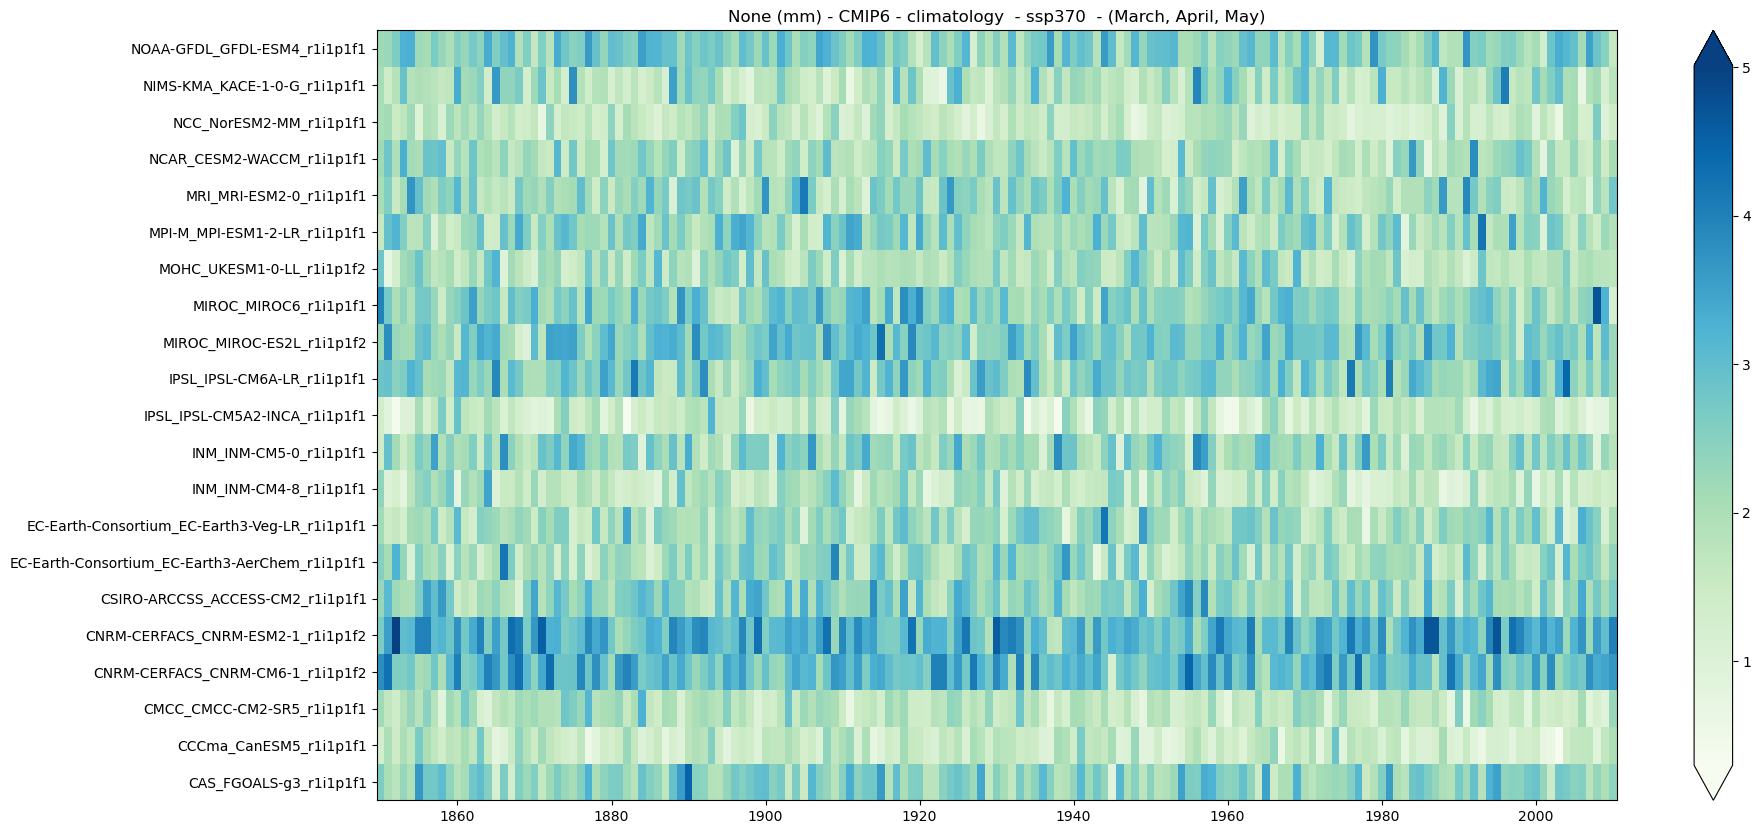

In [30]:
climate_stripe_fig = climate_stripe_plot(climate_stripe_ds, var, attrs, 
                                         cmap = 'GnBu', period = period,
                                         mode = mode, season = season)

#### b) Absolute change

In [31]:
period = slice(1850,2010)
baseline_period = slice(1980,2010)
mode = 'change'
diff = 'abs'

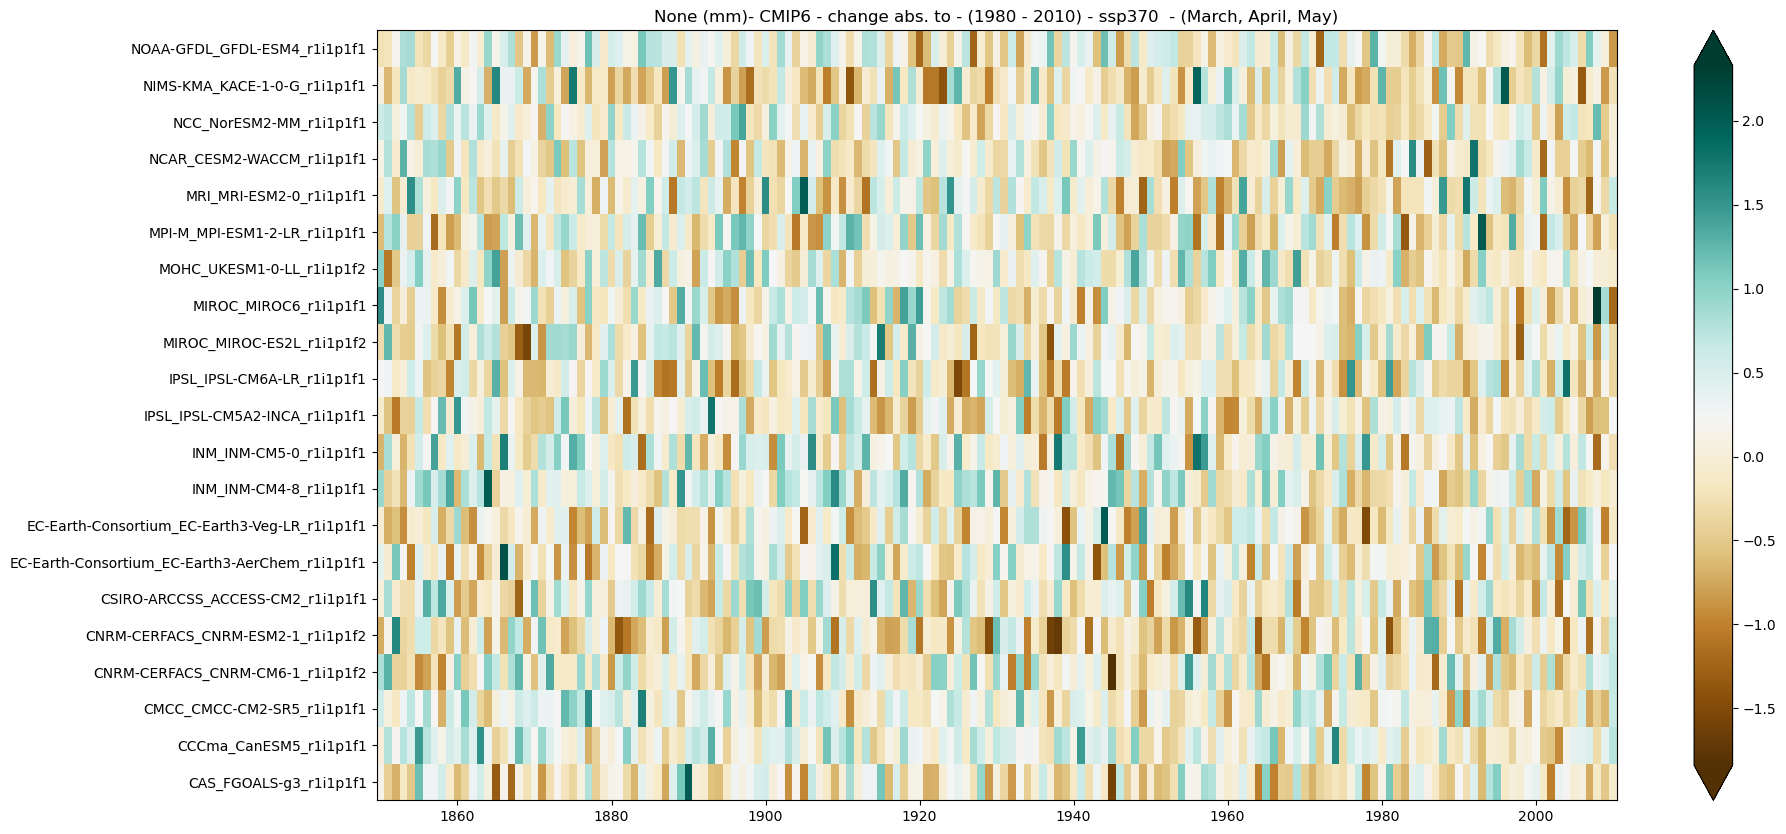

In [32]:
climate_stripe_fig = climate_stripe_plot(climate_stripe_ds, var, attrs, mode = mode, 
                                         diff = diff, season = season, cmap = 'BrBG',
                                         period = period, baseline_period = baseline_period)

#### c) Relative change

In [33]:
period = slice(1850,2010)
baseline_period = slice(1980,2010)
mode = 'change'
diff = 'rel'

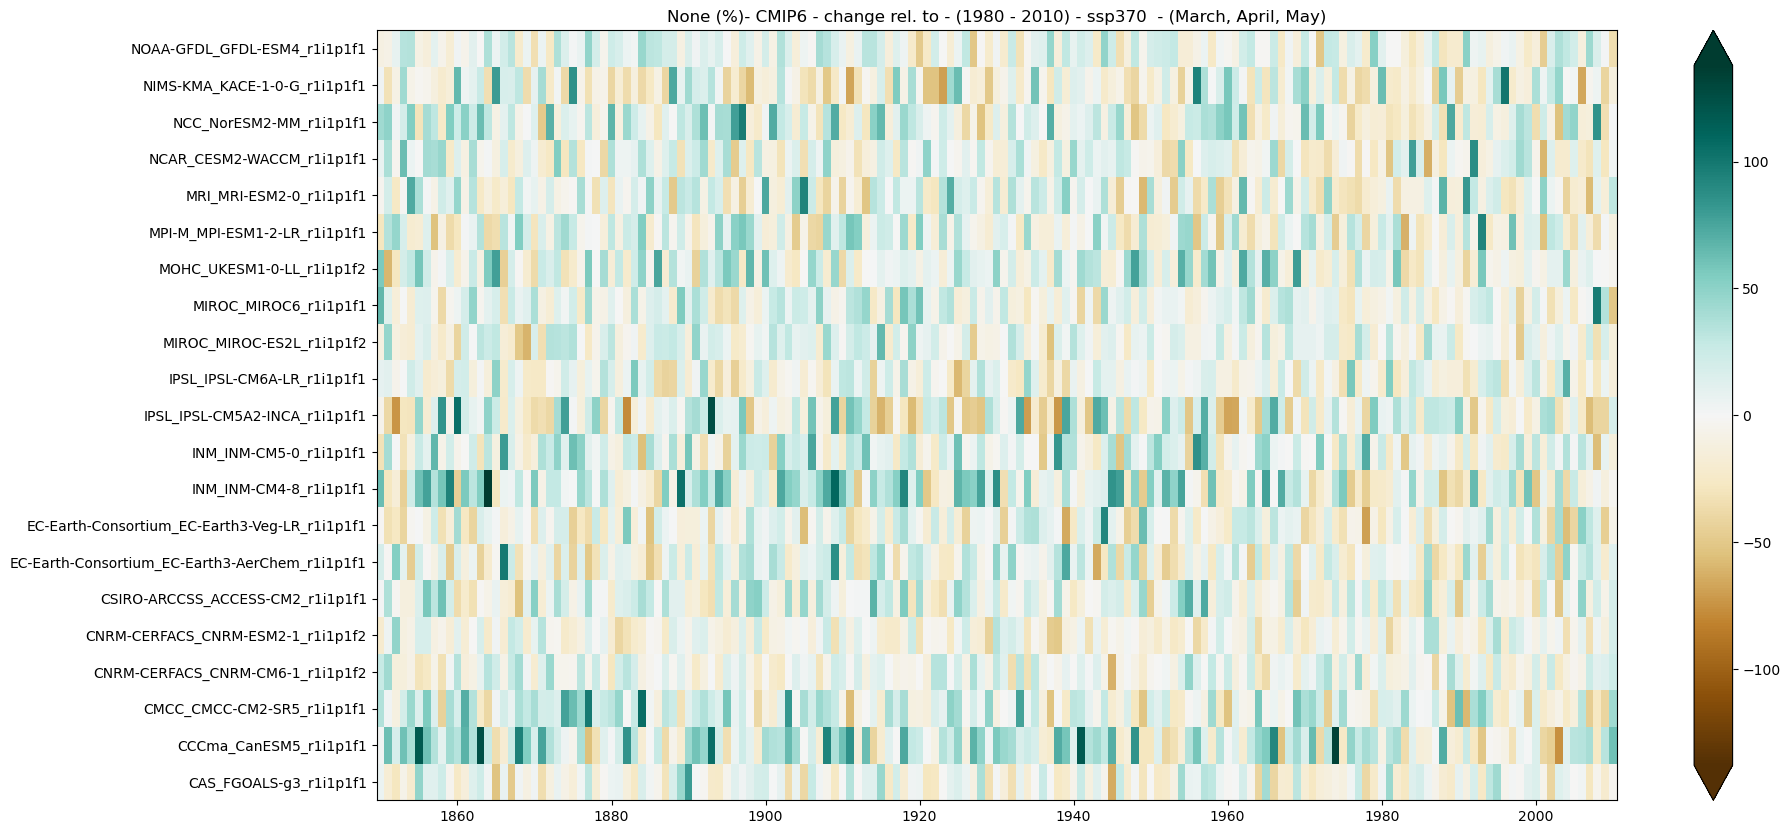

In [34]:
climate_stripe_fig = climate_stripe_plot(climate_stripe_ds, var, attrs, 
                                         mode = mode, diff = diff, season = season, cmap = 'BrBG', 
                                         period = period, baseline_period = baseline_period)

## Global Warming Levels
Here, the climate stripe is displayed for a specific Global Warming Level (GWL). To achieve this, the 20-year period in which each ensemble member reaches the chosen GWL is selected. The climate stripe is then shown, representing either climatology or change for this specific period and region (Spain in this notebook).

These periods are calculated in the notebook [GWLs.ipynb](GWLs.ipynb) for CMIP5 and CMIP6. For CORDEX, the results from the driving CMIP5 models are used.

In [35]:
GWL = '4'
season = [3, 4, 5] # Months

In [36]:
GWLs_ds = load_GWLs(project)
GWLs_members_with_period = select_member_GWLs(filtered_ds, GWLs_ds, project, scenario, GWL)

In [37]:
ds_filtered_GWL = get_selected_data(filtered_ds ,GWLs_members_with_period)

### Analysis

In [38]:
climate_stripe_GWL_ds = annual_weighted_average(ds_filtered_GWL, var, season) 

### Plot

In [39]:
mode = 'change'
diff = 'abs'
baseline_period= slice('1859','1870')

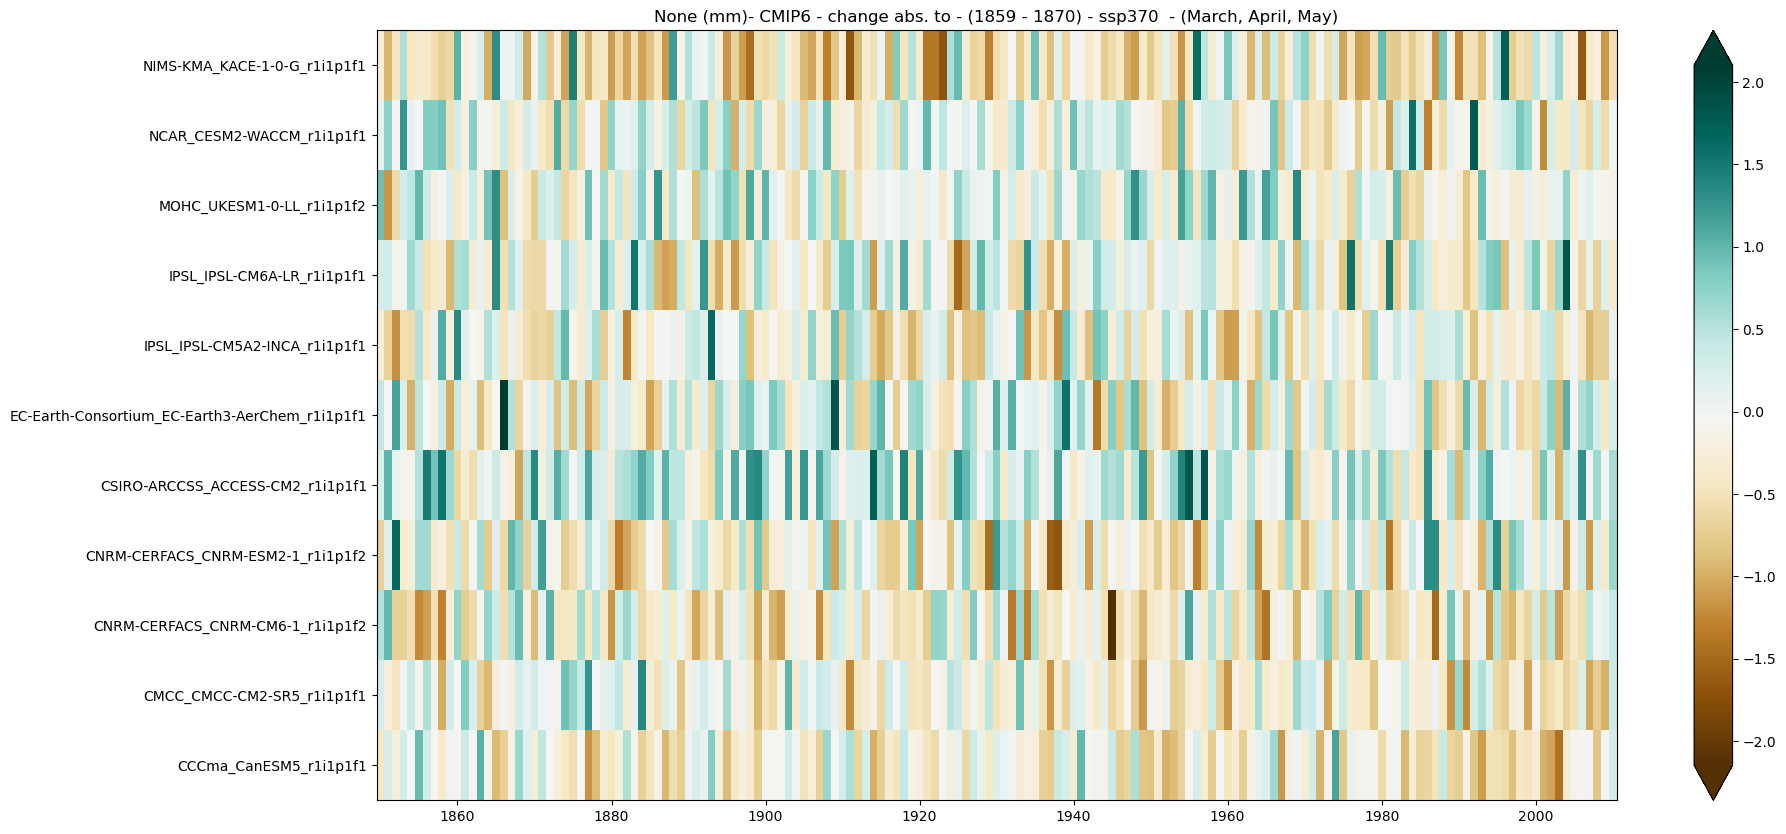

In [40]:
climate_stripe_fig = climate_stripe_plot(climate_stripe_GWL_ds, var, attrs, mode = mode, diff = diff,
                                         cmap = 'BrBG',
                                         period = period, baseline_period = baseline_period, season = season)